# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **1. Import Libraries and Load Data**

In [2]:
# Standard data and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
import keras

# Scikit-learn
import sklearn

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("PIL version:", Image.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)
print("sklearn version:", sklearn.__version__)


numpy version: 1.26.4
pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
PIL version: 10.4.0
tensorflow version: 2.19.0
keras version: 3.9.2
sklearn version: 1.5.1


In [6]:
import os

# Path to the root data folder
data_root = 'data'

# Storage
images = []
labels = []

# Get class names from subfolder names
class_names = sorted(os.listdir(data_root))
class_to_index = {cls_name: idx for idx, cls_name in enumerate(class_names)}

# Traverse subfolders and load PNGs
for cls_name in class_names:
    cls_folder = os.path.join(data_root, cls_name)
    if not os.path.isdir(cls_folder):
        continue

    for fname in os.listdir(cls_folder):
        if fname.endswith('.png'):
            fpath = os.path.join(cls_folder, fname)
            try:
                img = Image.open(fpath).convert('RGB')  # keep original size
                images.append(np.array(img) / 255.0)    # normalize to [0, 1]
                labels.append(class_to_index[cls_name])
            except Exception as e:
                print(f"Error loading {fpath}: {e}")

# Convert to numpy arrays
images = np.array(images, dtype=object)  # Use object if image shapes vary
labels = np.array(labels)

print(f"Loaded {len(images)} images from {len(class_names)} classes.")


Loaded 7625 images from 8 classes.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [7]:

def load_images_from_folders(data_root='data', normalize=True, verbose=True):
    """
    Load all .png images from subfolders of `data_root`, preserving original sizes.

    Parameters:
    - data_root (str): Root directory with class-named subfolders.
    - normalize (bool): Normalize pixel values to [0, 1] if True.
    - verbose (bool): Print status messages if True.

    Returns:
    - images (np.array): Array of image arrays (dtype=object if sizes vary).
    - labels (np.array): Numeric class labels.
    - class_to_index (dict): Mapping of class names to indices.
    """
    images = []
    labels = []

    class_names = sorted([
        name for name in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, name))
    ])
    class_to_index = {cls: idx for idx, cls in enumerate(class_names)}

    for cls_name in class_names:
        cls_folder = os.path.join(data_root, cls_name)
        for fname in os.listdir(cls_folder):
            if fname.endswith('.png'):
                fpath = os.path.join(cls_folder, fname)
                try:
                    img = Image.open(fpath).convert('RGB')  # no resizing
                    img_array = np.array(img)
                    if normalize:
                        img_array = img_array / 255.0
                    images.append(img_array)
                    labels.append(class_to_index[cls_name])
                except Exception as e:
                    if verbose:
                        print(f"Error loading {fpath}: {e}")

    images = np.array(images, dtype=object)  # original sizes → use dtype=object
    labels = np.array(labels)

    if verbose:
        print(f"Loaded {len(images)} images from {len(class_names)} classes.")

    return images, labels, class_to_index


In [8]:
# Load images from subdirectories (no resizing)
images, labels, label_map = load_images_from_folders('data')

# Reverse mapping for label to class name
index_to_class = {v: k for k, v in label_map.items()}


Loaded 7625 images from 7 classes.


In [12]:
import numpy as np
import pandas as pd

print(f"Total images loaded: {len(images)}")
print("Image types:", type(images), " | dtype:", images.dtype)

# Check label distribution
label_counts = pd.Series(labels).value_counts().sort_index()
for idx, count in label_counts.items():
    print(f"Class {index_to_class[idx]} ({idx}): {count} images")


Total images loaded: 7625
Image types: <class 'numpy.ndarray'>  | dtype: object
Class Cardboard (0): 540 images
Class Food_Waste (1): 1000 images
Class Glass (2): 750 images
Class Metal (3): 1000 images
Class Other (4): 1010 images
Class Paper (5): 1030 images
Class Plastic (6): 2295 images


### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

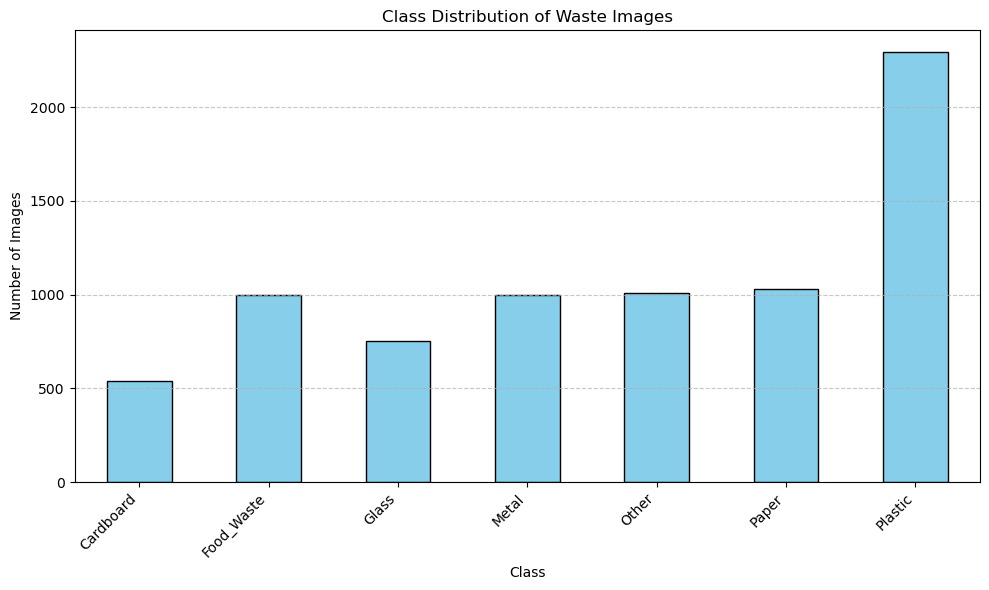

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert numeric labels back to class names
index_to_class = {v: k for k, v in label_map.items()}
label_names = [index_to_class[l] for l in labels]

# Count frequency of each class
label_counts = pd.Series(label_names).value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Class Distribution of Waste Images")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

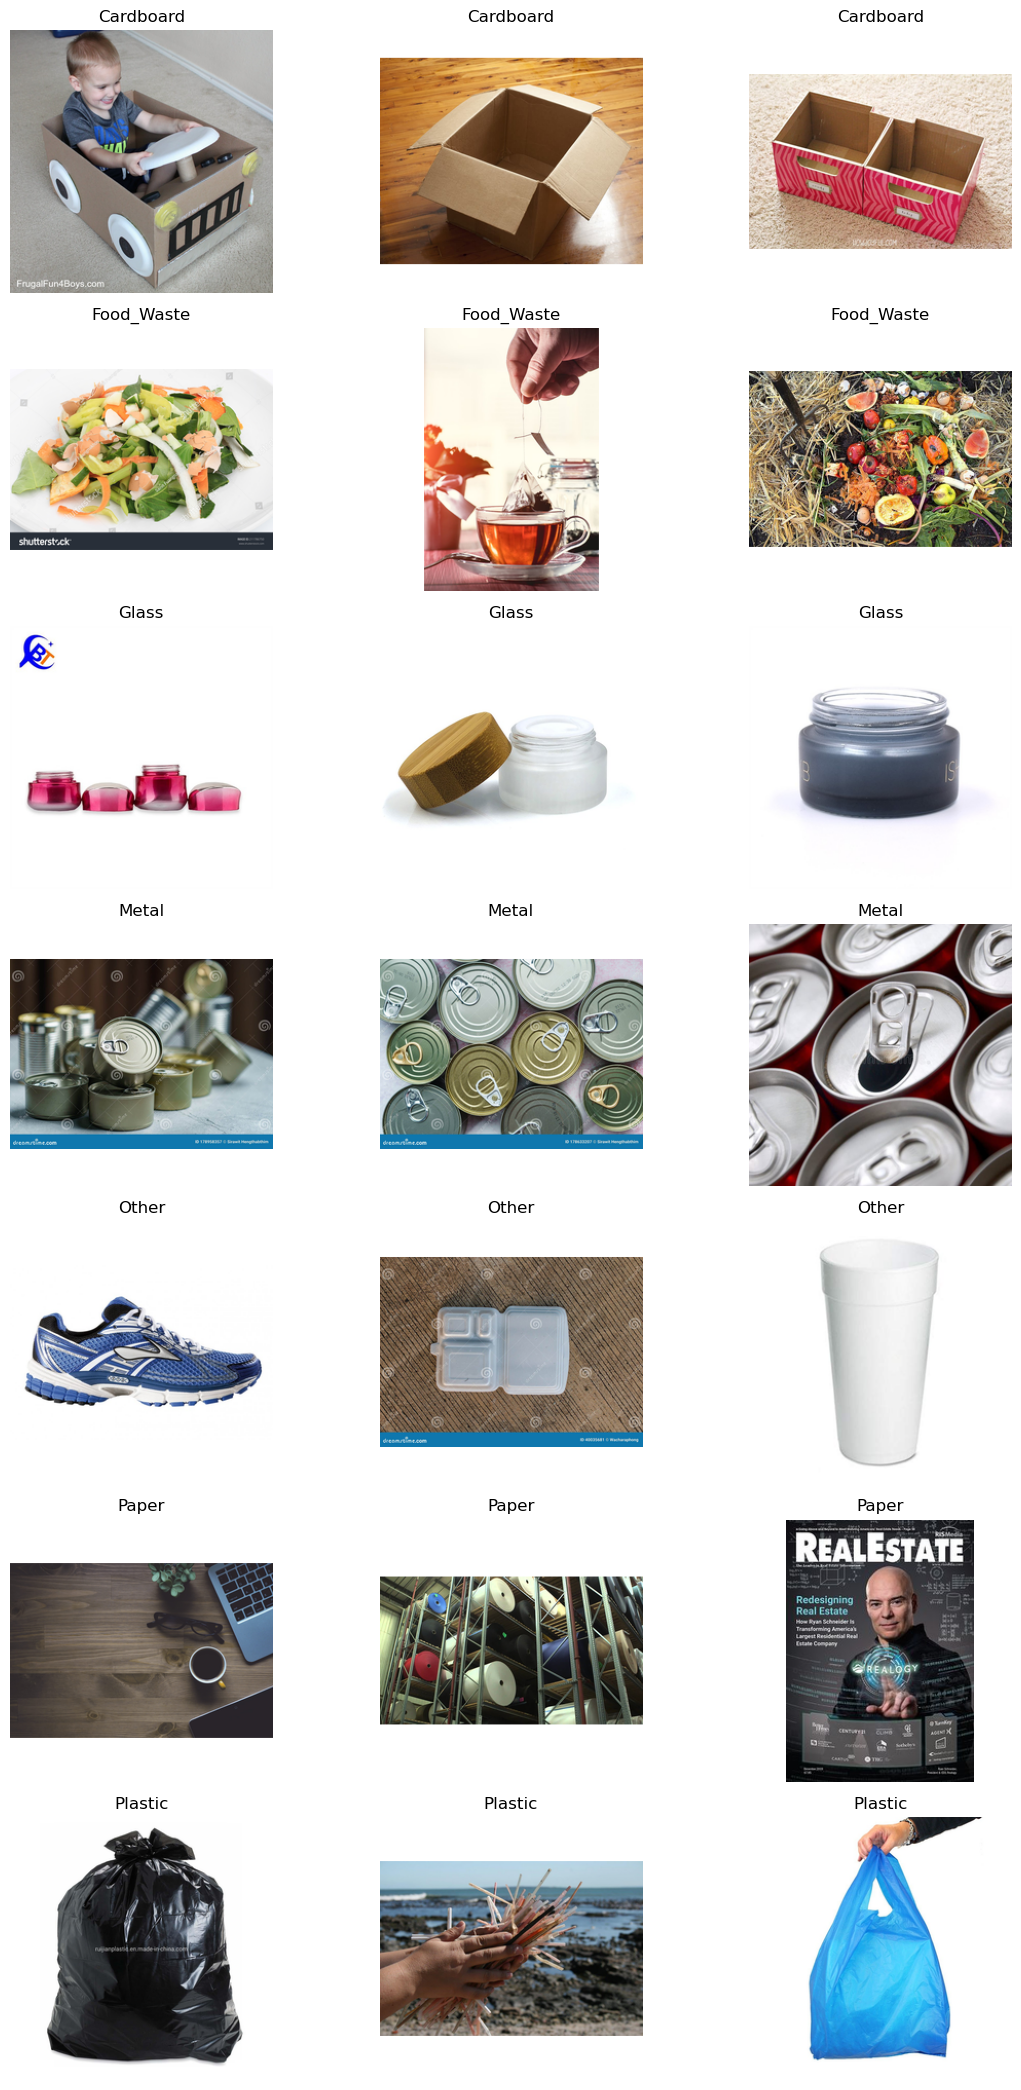

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Reverse label map
index_to_class = {v: k for k, v in label_map.items()}

# Get indices per class
class_to_indices = {label: [] for label in index_to_class}
for i, label in enumerate(labels):
    class_to_indices[label].append(i)

# Plot 3 images per class
n_cols = 3
n_rows = len(index_to_class)

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for class_idx, indices in class_to_indices.items():
    selected = random.sample(indices, min(3, len(indices)))  # take 3 random samples
    for j, idx in enumerate(selected):
        img_array = images[idx]
        if isinstance(img_array, np.ndarray):
            img = Image.fromarray((img_array * 255).astype(np.uint8))
        else:
            img = img_array  # already PIL.Image

        ax = plt.subplot(n_rows, n_cols, class_idx * n_cols + j + 1)
        ax.imshow(img)
        ax.set_title(f"{index_to_class[class_idx]}")
        ax.axis('off')

plt.tight_layout()
plt.show()



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [18]:
from collections import defaultdict
import numpy as np

# Initialize storage
class_dims = defaultdict(list)  # key: class label, value: list of (H, W)
index_to_class = {v: k for k, v in label_map.items()}

# Collect dimensions per class
for img, label in zip(images, labels):
    h, w = img.shape[:2]
    class_name = index_to_class[label]
    class_dims[class_name].append((h, w))

# Analyze dimensions per class
print("📁 Image Size Summary Per Class:")
overall_heights = []
overall_widths = []

for cls, dim_list in class_dims.items():
    dims = np.array(dim_list)
    min_h, min_w = dims.min(axis=0)
    max_h, max_w = dims.max(axis=0)
    
    overall_heights.extend(dims[:, 0])
    overall_widths.extend(dims[:, 1])
    
    print(f"- {cls}:")
    print(f"    Min size: {min_h} x {min_w}")
    print(f"    Max size: {max_h} x {max_w}")

# Final summary across all classes
overall_min_h = min(overall_heights)
overall_min_w = min(overall_widths)
overall_max_h = max(overall_heights)
overall_max_w = max(overall_widths)

print("\n📊 Overall Image Dimension Summary:")
print(f"Smallest image size: {overall_min_h} x {overall_min_w}")
print(f"Largest image size : {overall_max_h} x {overall_max_w}")


📁 Image Size Summary Per Class:
- Cardboard:
    Min size: 256 x 256
    Max size: 256 x 256
- Food_Waste:
    Min size: 256 x 256
    Max size: 256 x 256
- Glass:
    Min size: 256 x 256
    Max size: 256 x 256
- Metal:
    Min size: 256 x 256
    Max size: 256 x 256
- Other:
    Min size: 256 x 256
    Max size: 256 x 256
- Paper:
    Min size: 256 x 256
    Max size: 256 x 256
- Plastic:
    Min size: 256 x 256
    Max size: 256 x 256

📊 Overall Image Dimension Summary:
Smallest image size: 256 x 256
Largest image size : 256 x 256


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [21]:
from tensorflow.keras.utils import to_categorical

# Integer labels → One-hot encoded labels
labels_encoded = to_categorical(labels, num_classes=7)

print("Original label:", labels[0])
print("One-hot encoded:", labels_encoded[0])


Original label: 0
One-hot encoded: [1. 0. 0. 0. 0. 0. 0.]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [27]:
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp, labels_train, labels_temp = train_test_split(
    images, labels_encoded, labels,
    test_size=0.30,
    stratify=labels,
    random_state=42
)

# Step 2: Split temp into val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=labels_temp,
    random_state=42
)

print(f"Train set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")



Train set: 5337
Validation set: 1144
Test set: 1144


In [29]:
from PIL import Image
import numpy as np

def resize_images(image_list, target_size=(224, 224)):
    resized = []
    for img in image_list:
        img_pil = Image.fromarray((img * 255).astype(np.uint8))  # convert back to 0–255 if normalized
        img_resized = img_pil.resize(target_size)
        resized.append(np.array(img_resized) / 255.0)  # re-normalize to [0, 1]
    return np.array(resized)

In [31]:
X_train_resized = resize_images(X_train, target_size=(224, 224))
X_val_resized   = resize_images(X_val,   target_size=(224, 224))
X_test_resized  = resize_images(X_test,  target_size=(224, 224))

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [33]:
# Build and compile the model
import tensorflow as tf
from tensorflow.keras import layers, models

# Input shape – adjust this if you resize your images to a specific fixed size
INPUT_SHAPE = (224, 224, 3)  # Example target size for resizing
NUM_CLASSES = 7

model = models.Sequential()

# 1st Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# 2nd Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# 3rd Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Flatten and Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,271 (42.62 MB)

 Trainable params: 11,170,567 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [35]:
model.fit(
    X_train_resized, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_resized, y_val)
)


Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.2691 - loss: 2.3580 - val_accuracy: 0.2587 - val_loss: 4.0658
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 443ms/step - accuracy: 0.4160 - loss: 1.6423 - val_accuracy: 0.3147 - val_loss: 4.0739
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 441ms/step - accuracy: 0.4498 - loss: 1.5430 - val_accuracy: 0.3584 - val_loss: 2.2521
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 73s 438ms/step - accuracy: 0.5439 - loss: 1.2796 - val_accuracy: 0.4318 - val_loss: 1.6063
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 444ms/step - accuracy: 0.6221 - loss: 1.0880 - val_accuracy: 0.4834 - val_loss: 1.4069
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 73s 437ms/step - accuracy: 0.6965 - loss: 0.8776 - val_accuracy: 0.5262 - val_loss: 1.3548
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 441ms/step - accuracy: 0.7538 - loss: 0.7318 - val_accuracy: 0.5079 - val_loss: 1.4250
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 440ms/step - accuracy: 0.7766 - loss: 0

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [37]:
X_test_resized = resize_images(X_test, target_size=(224, 224))  # same as train size

In [41]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5550 - loss: 1.9708

Test Accuracy: 0.5682
Test Loss: 1.9677


In [45]:
from sklearn.metrics import classification_report
import numpy as np

# Convert predicted probabilities to class indices
y_pred_probs = model.predict(X_test_resized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_map.keys()))


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
              precision    recall  f1-score   support

   Cardboard       0.77      0.69      0.73        81
  Food_Waste       0.84      0.47      0.60       150
       Glass       0.79      0.30      0.44       113
       Metal       0.78      0.41      0.54       150
       Other       0.57      0.29      0.39       151
       Paper       0.38      0.65      0.48       155
     Plastic       0.54      0.82      0.65       344

    accuracy                           0.57      1144
   macro avg       0.67      0.52      0.55      1144
weighted avg       0.63      0.57      0.56      1144



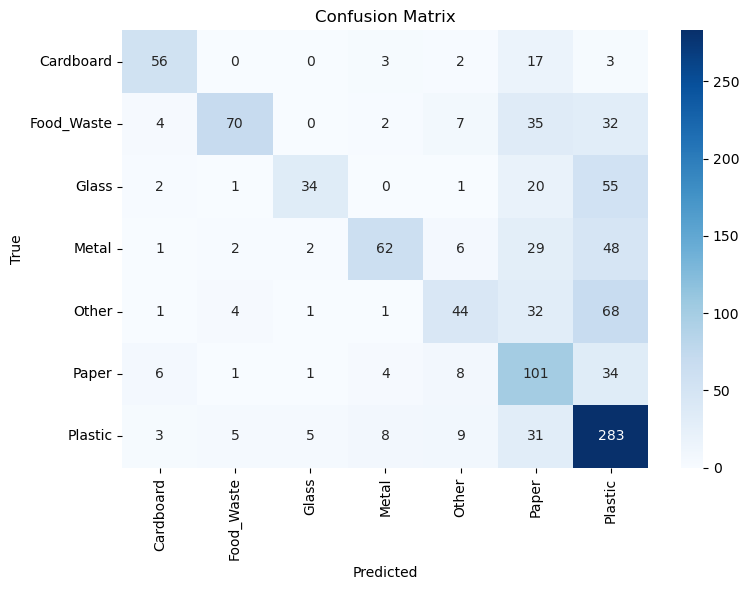

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#### **4.1 Create a Data Augmentation Pipeline**

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [52]:
def augment_images(X, y, augmenter, augment_factor=2):
    """
    Augments X and y using the provided ImageDataGenerator.
    
    Args:
        X (np.array): Training images (N, H, W, C)
        y (np.array): One-hot encoded labels (N, C)
        augmenter (ImageDataGenerator): augmentation pipeline
        augment_factor (int): how many times to replicate each image
    
    Returns:
        Augmented images and labels
    """
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        x = X[i]
        label = y[i]
        x = x.reshape((1,) + x.shape)  # add batch dimension

        # Generate 'augment_factor' new samples
        count = 0
        for batch in augmenter.flow(x, batch_size=1):
            augmented_X.append(batch[0])
            augmented_y.append(label)
            count += 1
            if count >= augment_factor:
                break

    return np.array(augmented_X), np.array(augmented_y)


In [54]:
# Augment training set by 2x
X_augmented, y_augmented = augment_images(X_train_resized, y_train, augmenter, augment_factor=2)

# Combine with original training data
X_train_augmented = np.concatenate([X_train_resized, X_augmented])
y_train_augmented = np.concatenate([y_train, y_augmented])

print("Original train size:", X_train_resized.shape)
print("Augmented train size:", X_train_augmented.shape)


Original train size: (5337, 224, 224, 3)
Augmented train size: (16011, 224, 224, 3)


In [56]:
history_aug = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_resized, y_val)
)


Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 211s 421ms/step - accuracy: 0.5451 - loss: 1.4768 - val_accuracy: 0.5000 - val_loss: 1.7924
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 212s 422ms/step - accuracy: 0.5907 - loss: 1.1310 - val_accuracy: 0.5227 - val_loss: 1.3483
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 212s 422ms/step - accuracy: 0.7534 - loss: 0.7344 - val_accuracy: 0.5236 - val_loss: 1.4186
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 215s 428ms/step - accuracy: 0.8178 - loss: 0.5403 - val_accuracy: 0.6023 - val_loss: 1.3395
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 214s 427ms/step - accuracy: 0.8555 - loss: 0.4169 - val_accuracy: 0.6014 - val_loss: 1.4321
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 214s 428ms/step - accuracy: 0.8832 - loss: 0.3418 - val_accuracy: 0.5743 - val_loss: 1.5953
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 215s 430ms/step - accuracy: 0.9018 - loss: 0.2817 - val_accuracy: 0.3855 - val_loss: 5.2825
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 216s 432ms/step - accuracy: 0.9092 -

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

We began by exploring a multi-class waste image classification dataset consisting of seven categories: Cardboard, Food Waste, Glass, Metal, Other, Paper, and Plastic. The dataset was organized into subdirectories representing each class. An initial analysis revealed class imbalance and significant variability in image sizes. Images were normalized and resized to a consistent shape of 224 × 224 pixels for compatibility with a convolutional neural network (CNN). Labels were one-hot encoded, and the dataset was stratified into training (70%), validation (15%), and test (15%) sets to ensure balanced class representation across splits.

 CNN with three convolutional blocks, batch normalization, dropout, and a dense classification head was trained on the original waste image dataset. During initial training, the model showed significant improvement in training accuracy but struggled to generalize well to the validation set. The model reached a training accuracy of 94.8% and a validation accuracy of 56.9% by epoch 15, with a final validation loss of 1.88. These results indicated a degree of overfitting and insufficient exposure to the full variability of the dataset, especially considering class imbalance and limited representation of certain waste types.

To address this, a comprehensive data augmentation pipeline was introduced using random rotations, zooming, shifts, and horizontal flipping. The training data was augmented twofold and combined with the original dataset. Upon retraining, the model achieved a training accuracy of 92.4% and a validation accuracy of 66.4%, with a reduced validation loss of 1.59. These metrics reflect a notable improvement in generalization, with nearly a 10% absolute gain in validation accuracy and better stability in validation loss, suggesting that the augmentation strategy helped mitigate overfitting and improve robustness. Although room for improvement remains, especially on underrepresented classes, augmentation significantly enhanced the model’s ability to generalize across diverse real-world waste image inputs.

